# Proyecto 1 - Muestra pequeña

#### Cristina Bautista - 161260
#### Abril Palencia - 18198 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
# from pandas_profiling import ProfileReport
import re


%matplotlib inline

In [2]:
df1 = pd.read_csv('dataset/dataset-part1.csv')
df2 = pd.read_csv('dataset/dataset-part2.csv')
df3 = pd.read_csv('dataset/dataset-part3.csv')
df4 = pd.read_csv('dataset/dataset-part4.csv')

In [3]:
df_final = pd.concat([df1, df2, df3, df4])

In [4]:
df_final = df_final.drop(labels=['FIREWALL_EVENT', 'FLOW_ACTIVE_TIMEOUT', 'FLOW_DURATION_MICROSECONDS', 'FLOW_END_SEC', 
                          'FLOW_INACTIVE_TIMEOUT', 'FLOW_START_SEC', 'FRAME_LENGTH', 'IPV4_DST_ADDR', 
                          'IPV4_SRC_ADDR', 'MAX_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'MIN_IP_PKT_LEN', 'PROTOCOL_MAP', 
                          'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 
                          'RETRANSMITTED_OUT_PKTS', 'DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES', 
                          'L7_PROTO_NAME'], axis=1)

In [5]:
df_final_prueba = df_final.sample(n = 10000000)

In [6]:
# df_final_prueba['LABEL'].value_counts()

In [7]:
valores = ['UDP Scan', 'NULL Scan', 'XMAS Scan', 'FIN Scan']

In [8]:
df_final_prueba = df_final_prueba[df_final_prueba['LABEL'].isin(valores) == False]

In [9]:
valores2 = [47, 58]

In [10]:
df_final_prueba = df_final_prueba[df_final_prueba['PROTOCOL'].isin(valores2) == False]

In [11]:
# df_final_prueba['LABEL'].value_counts()

In [12]:
df_final_prueba['LABEL'].replace({"Normal flow": 0, "Denial of Service R-U-Dead-Yet": 1,
                          "Denial of Service Slowloris": 2, "SYN Scan - aggressive": 3}, inplace=True)

In [13]:
# slowloris = df_final_prueba[df_final_prueba['LABEL'] == 2]
# denial_dead = df_final_prueba[df_final_prueba['LABEL'] == 1]

In [14]:
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

In [15]:
# sorted(Counter(df_final_prueba['LABEL']).items())

In [16]:
# pd.value_counts(df_final_prueba['LABEL']).plot.bar()
# plt.title('Label s histogram')
# plt.xlabel('Labels')
# plt.ylabel('Frequency')
# df_final_prueba['LABEL'].value_counts()

In [17]:
X = df_final_prueba
y = df_final_prueba[['LABEL']]
X = X.drop(['LABEL'], axis=1)

In [18]:
# y = pd.DataFrame(y)

In [19]:
y.value_counts()

LABEL
0        842167
3         62149
1         56314
2         21431
dtype: int64

In [20]:
# X.shape, y.shape#y.reshape(-1,1)

In [21]:
ros = RandomOverSampler(random_state=5)
X_resample, y_resample = ros.fit_resample(X, y)

In [22]:
# y_resample.value_counts()

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# X_train, X_val_test, y_train, y_val_test = train_test_split(X_resample, y_resample, train_size = 0.55, 
#                                                              test_size=0.45, random_state = 5)

In [25]:
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size = 0.67, 
#                                                              test_size=0.33, random_state = 5)

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
# dTree = DecisionTreeClassifier()
# dTree = dTree.fit(X_train, y_train)

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [29]:
# target_prediction = dTree.predict(X_val)
# y_prob_pred = dTree.predict_proba(X_val)

In [30]:
# accuracy_score(y_val, target_prediction)

In [31]:
# confusion_matrix(y_val, target_prediction)

In [32]:
target_names=[0, 1, 2, 3]
target_names=list(map(str,target_names))

In [33]:
# print(classification_report(y_val, target_prediction, target_names=target_names))

In [34]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean, std

In [35]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=1)

In [36]:
# n_scores = cross_val_score(dTree, y_val, target_prediction, scoring='accuracy', 
#                            cv=cv, n_jobs=-1)

In [37]:
# print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [38]:
# # roc curve for classes
# fpr = {}
# tpr = {}
# thresh ={}

# n_class = 4

# for i in range(n_class):    
#     fpr[i], tpr[i], thresh[i] = roc_curve(y_val, y_prob_pred[:, i], pos_label=i)
    
# # plotting    
# plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=fpr[0])
# plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Result')
# plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Result')
# plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Result')
# plt.title('Multiclass ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive rate')
# plt.legend(loc='best')

In [39]:
X_train_lr, X_val_test_lr, y_train_lr, y_val_test_lr = train_test_split(X_resample, y_resample, train_size = 0.55, 
                                                             test_size=0.45, random_state = 0)

In [40]:
X_val_lr, X_test_lr, y_val_lr, y_test_lr = train_test_split(X_val_test_lr, y_val_test_lr, train_size = 0.67, 
                                                             test_size=0.33, random_state = 0)

In [41]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [42]:
lr.fit(X_train_lr, y_train_lr)

/Users/abrilpalencia/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(multi_class='multinomial')

In [43]:
target_predictionLR = lr.predict(X_val_lr)
y_prob_predLR = lr.predict_proba(X_val_lr)

In [44]:
accuracy_score(y_val_lr, target_predictionLR)

0.9400070693435651

In [45]:
confusion_matrix(y_val_lr, target_predictionLR)

array([[205135,   8186,  14279,  26807],
       [     0, 241803,  11660,      0],
       [     0,      0, 253742,      0],
       [     0,      0,      0, 254041]])

In [46]:
print(classification_report(y_val_lr, target_predictionLR, target_names=target_names))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89    254407
           1       0.97      0.95      0.96    253463
           2       0.91      1.00      0.95    253742
           3       0.90      1.00      0.95    254041

    accuracy                           0.94   1015653
   macro avg       0.94      0.94      0.94   1015653
weighted avg       0.94      0.94      0.94   1015653



In [47]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=1)

In [48]:
n_scoreslr = cross_val_score(lr, y_val_lr, target_predictionLR, scoring='accuracy', 
                           cv=cv, n_jobs=-1)

In [49]:
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scoreslr), std(n_scoreslr)))

Mean Accuracy: 0.940 (0.001)


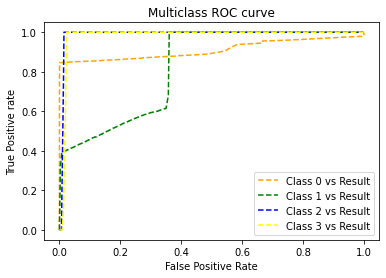

In [50]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_val_lr, y_prob_predLR[:, i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Result')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Result')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Result')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Result')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')